In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Library**

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# **Get Data and encode labels**

In [ ]:
TRAIN_DIRECTORY = "/content/drive/MyDrive/dataset/train/"
TEST_DIRECTORY = "/content/drive/MyDrive/dataset/test/"

CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

train_data = []
train_labels = []
test_data = []
test_labels = []

[INFO] loading images...


In [ ]:
for category in CATEGORIES:
    path = os.path.join(TRAIN_DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	train_data.append(image)
    	train_labels.append(category)
		 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(train_labels)  #encode labels to 0 , 1 
labels = to_categorical(labels)

data = np.array(train_data, dtype="float32")
labels = np.array(labels)

(trainX, validateX, trainY, validateY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
print(len(trainX))
print(len(validateX))

2464
617


# **Build Model**

In [ ]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7efba0a3b9d0>>

# **Train Model**

In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validateX, validateY),
	validation_steps=len(validateX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
77/77 [==============================] - 119s 1s/step - loss: 0.4422 - accuracy: 0.8397 - val_loss: 0.1762 - val_accuracy: 0.9676
Epoch 2/20
77/77 [==============================] - 114s 1s/step - loss: 0.1768 - accuracy: 0.9602 - val_loss: 0.0937 - val_accuracy: 0.9757
Epoch 3/20
77/77 [==============================] - 113s 1s/step - loss: 0.1170 - accuracy: 0.9704 - val_loss: 0.0731 - val_accuracy: 0.9757
Epoch 4/20
77/77 [==============================] - 113s 1s/step - loss: 0.0905 - accuracy: 0.9756 - val_loss: 0.0622 - val_accuracy: 0.9806
Epoch 5/20
77/77 [==============================] - 113s 1s/step - loss: 0.0759 - accuracy: 0.9805 - val_loss: 0.0533 - val_accuracy: 0.9806
Epoch 6/20
77/77 [==============================] - 114s 1s/step - loss: 0.0693 - accuracy: 0.9817 - val_loss: 0.0467 - val_accuracy: 0.9822
Epoch 7/20
77/77 [==============================] - 115s 1s/step - loss: 0.0585 - accuracy: 0.9821 - val_loss: 0.0446 - val_accura

# **Get Model Accuacy and validation**

In [ ]:
print("Loss                 : {}".format(np.array(H.history["loss"]).mean()))
print("Accuracy             : {}".format(np.array(H.history["accuracy"]).mean()*100))
print("Validation Accuracy  : {}".format(np.array(H.history["val_accuracy"]).mean()*100))

Loss                 : 0.07584733963012695
Accuracy             : 97.76988625526428
Validation Accuracy  : 98.20097267627716


In [ ]:
for category in CATEGORIES:
    path = os.path.join(TEST_DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	test_data.append(image)
    	test_labels.append(category)
		 # perform one-hot encoding on the labels
t_labels = lb.fit_transform(test_labels)  #encode labels to 0 , 1 
t_labels = to_categorical(t_labels)

testX = np.array(test_data, dtype="float32")
testY = np.array(t_labels)

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predictY = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictY_one_dimension = np.argmax(predictY, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predictY_one_dimension,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.96      0.98       380
without_mask       0.96      0.99      0.98       380

    accuracy                           0.98       760
   macro avg       0.98      0.98      0.98       760
weighted avg       0.98      0.98      0.98       760



In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


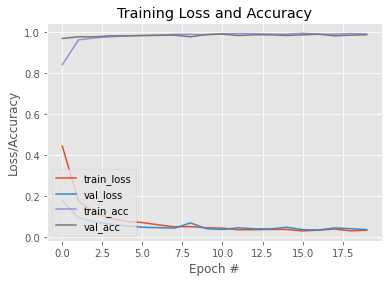

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
def drawCurves(model):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_confusion_Matrix(matrix):
  ax = sns.heatmap(matrix, annot=True, cmap='Blues' , fmt="d")
  ax.set_title('Face Mask Detection Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Mask Detection')
  ax.set_ylabel('Actual Mask Detection')
  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['With Mak','Without Mask', 'Virginia'])
  ax.yaxis.set_ticklabels(['With Mak','Without Mask', 'Virginia'])
  ## Display the visualization of the Confusion Matrix.
  plt.show()

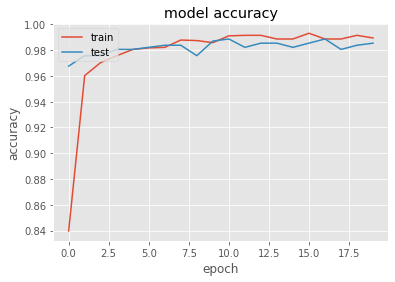

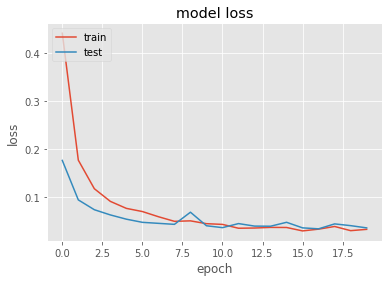

In [ ]:
drawCurves(H)

In [ ]:
testY_one_dimension = np.argmax(testY, axis=1)

In [ ]:
cf_matrix = confusion_matrix(testY_one_dimension , predictY_one_dimension)

In [ ]:
cf_matrix

array([[366,  14],
       [  2, 378]])

In [ ]:
test_Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / (cf_matrix[0][0] + cf_matrix[1][1] + cf_matrix[1][0] + cf_matrix[0][1])
print("Test Accuracy : {}".format(test_Accuracy * 100))
cf_matrix[0][0] + cf_matrix[1][1]

Test Accuracy : 97.89473684210527


744

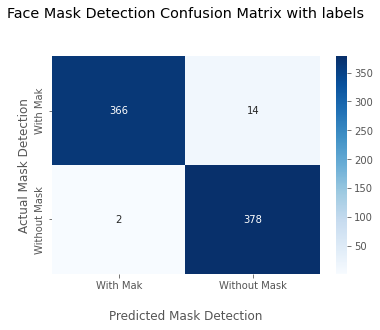

In [ ]:
draw_confusion_Matrix(cf_matrix)

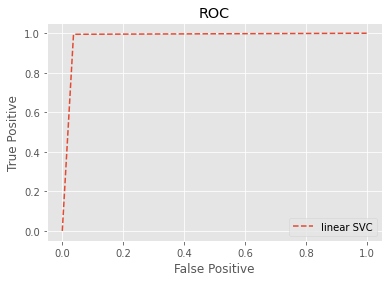

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
linearauc = roc_auc_score(testY_one_dimension, predictY_one_dimension)
linearfpr, lineartpr, threadshot = roc_curve(testY_one_dimension, predictY_one_dimension) #linearfpr holds the False Positive rate, lineartpr holds True Positive rate

#plotting the ROC curve
plt.plot(linearfpr, lineartpr,linestyle='--', label='linear SVC')
plt.title('ROC')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

In [66]:
print(len(trainX))
print(len(validateX))
print(len(testX))

2464
617
760
